In [1]:
import pickle
import pandas as pd
import numpy as np
from Bio import SeqIO
from pprint import pprint

In [2]:
titers = pickle.load(open('./raw_titers.p', 'rb')) # Titers
genotypes = pd.read_csv('../data/smith2015/genotypes.csv') 
genotypes = { i[0]:i[1] for i in zip(genotypes['accession'], genotypes['RicoGenotype']) } # Accession : Genotypes
viruses = [ v.description for v in 
           SeqIO.parse(open('/Users/Sidney/nextstrain/fauna/data/dengue.fasta', 'r'), 'fasta')] # Headers -> Acc : Strain
strain_genotypes = {'DENV2/PAPUANEWGUINEA/NEWGUINEAC/1944':'Southeast Asia', 'DENV2/PERU/IQT2913/1996': 'American'}
for v in viruses:
    strain, acc = v.split('|')[:2]
    if acc in genotypes:
        strain_genotypes[strain] = genotypes[acc] # Strain : Genotype

In [3]:
for t in titers: # Genotype : Titers
    t['serum_serotype'] = t['serumID'].split('/')[0]
    t['virus_serotype'] = t['virus'].split('/')[0]
    t['serum_genotype'] = strain_genotypes[t['serumID'].split('|')[0]]
    t['virus_genotype'] = strain_genotypes[t['virus']]
titers = pd.DataFrame(titers, columns=['virus', 'virus_serotype', 'virus_genotype', 'serumID', 'serum_serotype', 'serum_genotype', 'titer'])
titers['log2_titer'] = np.log2(titers['titer'])    

In [4]:
def find_autologous(sera, titer_vals):
    autologous_vals = []  
    for s in sera:
        try:
            a = titers.loc[(titers['virus'] == s.split('|')[0]) &       # Find where virus = sera
                (titers['serumID'] == s) ]['log2_titer']                # and sera = sera
            assert len(a) <= 1 # Should be exactly 1 autologous value
            autologous_vals.append(a.values[0])
        except AssertionError:
            print 'Multiple autologous titers found for this serum:'
            print titers.loc[(titers['virus'] == s.split('|')[0]) & (titers['serumID'] == s) ]
            raise AssertionError
        except IndexError:
            autologous_vals.append(None)
    
    normalized_vals = []
    for autologous, raw in zip(autologous_vals, titer_vals):
        if autologous != None:
            normalized_vals.append(autologous - raw)
        else:
            normalized_vals.append(None)
    return pd.Series(normalized_vals)
    
def find_max(sera, titer_vals):
    max_vals = [ titers.groupby(['serumID'])['log2_titer'].max()[s] for s in sera ]
    normalized_vals = [ Max - raw for Max, raw in zip(max_vals, titer_vals) ]
    return pd.Series(normalized_vals)

titers['autologous_norm'] = find_autologous(titers['serumID'], titers['log2_titer'])
titers['max_norm'] = find_max(titers['serumID'], titers['log2_titer'])
titers['sero_match'] = (titers['virus_serotype'] == titers['serum_serotype'])


In [7]:
divergence = pickle.load(open('./divergence.p', 'rb'))
tidy_divergence = []
for index, series in titers.iterrows():
    tidy_divergence.append(divergence.at[series['serumID'].split('|')[0], series['virus']])
titers['divergence'] = pd.Series(tidy_divergence)

In [21]:
genotype_raw_titers = titers.groupby(['serum_genotype', 'virus_genotype', 'sero_match', 'divergence'], as_index=False).log2_titer.mean()
genotype_max_titers = titers.groupby(['serum_genotype', 'virus_genotype', 'sero_match', 'divergence'], as_index=False).max_norm.mean()
genotype_autologous_titers = titers.groupby(['serum_genotype', 'virus_genotype', 'sero_match', 'divergence'], as_index=False).autologous_norm.mean()

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

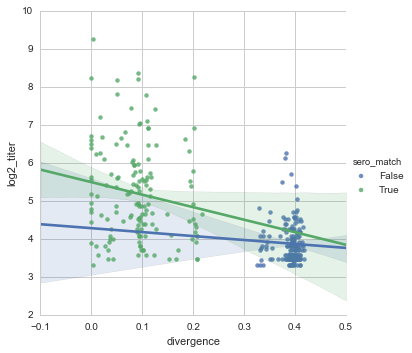

In [22]:
sns.set_style('whitegrid')
plot = sns.lmplot('divergence', 'log2_titer', genotype_raw_titers , hue='sero_match')

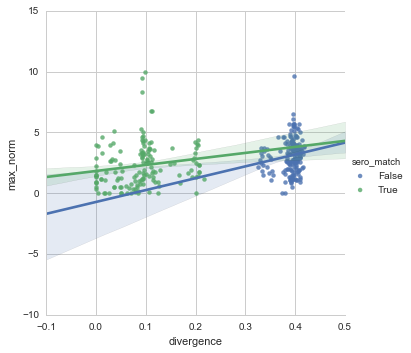

In [23]:
plot = sns.lmplot('divergence', 'max_norm', genotype_max_titers , hue='sero_match')

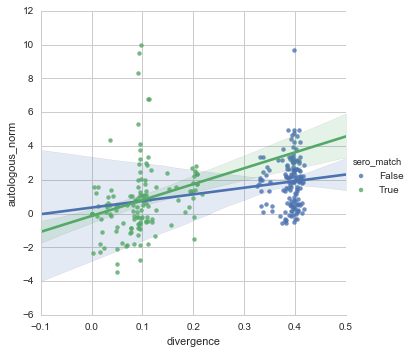

In [24]:
plot = sns.lmplot('divergence', 'autologous_norm', genotype_autologous_titers , hue='sero_match')